In [189]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [190]:
def load_data(resume_path, info_path):
    resume = pd.read_excel(resume_path)
    info = pd.read_excel(info_path)
    df = pd.merge(resume, info, how="left", on="employee_code")
    df.columns = [remove_space(name) for name in df.columns.to_list()]
    return df


In [191]:
def remove_space(text):
    text = re.sub(r'\s+$', '', text)
    text = re.sub(r'^\s+', '', text)
    return text

In [192]:
def format_date(date):
    try:
        date = re.sub(r'\n', '', date)
        date = re.sub(r'\u200b', '', date)
        date = remove_space(date)
        date = re.sub("[Cc][Uu][Rr][Rr][Ee][Nn][Tt]", "Present", date)
        date = re.sub("[Pp][Rr][Ee][Ss][Ee][Nn][Tt]", "Present", date)
        date = re.sub("[Oo]ngoing", "Present", date)
        date = re.sub("Feburary", "February", date)
        date = re.sub("J ULY", "JULY", date)
        date = re.sub("To", "-", date)
        date = re.sub("[Nn][Oo][Ww]", "Present", date)
        date = re.sub("[Tt]ill [Dd]ate", "- Present", date)
        date = re.sub(r"\sto\s", " - ", date)
        date = re.sub(r"[Ff][Ee][Bb][Uu][Aa][Rr][Yy]", "February", date)
        date = re.sub(r"—", " - ", date)
        date = re.sub(r"–", " - ", date)
        date = re.sub(r"–", " - ", date)
        date = re.sub(r"[\’]", " ", date)
        date = re.sub(r"[0-9]{4}[\,]", " - ", date)
        date = re.sub(r"-", " - ", date)
        date = re.sub(r" -", " - ", date)
        date = re.sub(r"- ", " - ", date)
        date = re.sub(r"/", " ", date)
        date = re.sub(r"([0-9]+)(\syear[s]*)", " - ", date)
        date = re.sub(r"([0-9]+)(\s[Mm]onth[s]*.*)", " - ", date)
        date = re.sub(r"\s+", " ", date)
        date = re.sub(r"(.*)\s18", r"\1 2018", date)
        date = re.sub(r"(.*)\s12", r"\1 2012", date)
        date = re.sub(r"(.*)\s15", r"\1 2015", date)
        date = re.sub(r"(.*)\s16", r"\1 2016", date)
        date = re.sub(r"(.*)\s14", r"\1 2014", date)
        return date
    except TypeError:
        return " - "

In [193]:
# format all
def format_all(df, colname_lst):
    for colname in colname_lst:
        resume_incl_hire[colname] = resume_incl_hire[colname].apply(format_date)
    return df

In [194]:
def calculate_num_month(start_date, end_date):
    try:
        num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
        return num_months
    except TypeError:
        return "unknown"

In [195]:
def work_length_calculater(df, colname, hire="Hire Date"):
    """

    :param df: a dataframe with formatted work date
    :param colname: a column name of the work used to be calculated length
    :param hire: a column name of hire date, default is "Hire Date"
    :return:
    """
    start = df[colname].str.split(" - ", expand=True)[0]
    end = df[colname].str.split(" - ", expand=True)[1]
    hire = df[hire]
    new = pd.concat([end, hire], axis=1).rename(columns={1: "end"})
    new.end = new.apply(
        lambda row: row["Hire Date"] if "Present" in row['end'] else row[
            "end"], axis=1)
    new = pd.concat([new, start], axis=1).rename(columns={0: "start"})
    new.end = pd.to_datetime(new.end)
    new.start = pd.to_datetime(new.start)
    new["num_month"] = new.apply(
        lambda row: calculate_num_month(row.start, row.end), axis=1)
    df = new[["start", "end", "num_month"]]
    return df

In [202]:
def avg_work_calculater(df, colname_lst, hire="Hire Date"):
    """
    calculate work length for all jobs and calculate the avg work experience

    :param df: a dataframe with formatted work date
    :param colname_lst: column names of all work
    :param hire: a column name of hire date, default is "Hire Date"
    :return: a dataframe containing all work length and avg work length
    """
    work1 = work_length_calculater(df, colname_lst[0], hire)["num_month"]
    work2 = work_length_calculater(df, colname_lst[1], hire)["num_month"]
    work3 = work_length_calculater(df, colname_lst[2], hire)["num_month"]
    work4 = work_length_calculater(df, colname_lst[3], hire)["num_month"]
    work5 = work_length_calculater(df, colname_lst[4], hire)["num_month"]
    work6 = work_length_calculater(df, colname_lst[5], hire)["num_month"]
    work7 = work_length_calculater(df, colname_lst[6], hire)["num_month"]
    df_all = pd.concat([work1, work2, work3, work4, work5, work6, work7],
                       axis=1)
    df_all.columns = ["work1", "work2", "work3", "work4", "work5", "work6",
                      "work7"]

    # df_all['num'] = df_all.count(axis=1)
    # df_all['total'] = df_all.sum(axis=1)
    df_all["work1"] = df_all.work1.apply(lambda x: -x if x < 0 else x)
    df_all["work2"] = df_all.work2.apply(lambda x: -x if x < 0 else x)
    df_all["work3"] = df_all.work3.apply(lambda x: -x if x < 0 else x)
    df_all["work4"] = df_all.work4.apply(lambda x: -x if x < 0 else x)
    df_all["work5"] = df_all.work5.apply(lambda x: -x if x < 0 else x)
    df_all["work6"] = df_all.work6.apply(lambda x: -x if x < 0 else x)
    df_all["work7"] = df_all.work7.apply(lambda x: -x if x < 0 else x)
    df_all['avg'] = (df_all.sum(axis=1) / df_all.count(axis=1)).round(2)
    df_all["employee_code"] = df.employee_code
    df_all = df_all[
        ["employee_code", "work1", "work2", "work3", "work4", "work5", "work6",
         "work7", "avg"]]
    companys = df[
        ["work1_company", "work2_company", "work3_company", "work4_company",
         "work5_company", "work6_company", "work7_company"]]
    df_all2 = pd.concat([df_all, companys], axis=1)
    df_all3 = (df_all2[
        ["employee_code", "work1_company", "work1", "work2_company",
         "work2", "work3_company",
         "work3", "work4_company", "work4", "work5_company",
         "work5", "work6_company", "work6", "work7_company", "work7", "avg"]]
        .rename(
        columns={"work1": "work1_length", "work2": "work2_length",
                 "work3": "work3_length",
                 "work4": "work4_length", "work5": "work5_length",
                 "work6": "work6_length",
                 "work7": "work7_length"}))
    return df_all3

In [203]:
def job_hopper(num, threshold):
    if pd.isna(num):
        return np.nan
    elif num < threshold:
        return 1
    else:
        return 0

In [204]:
# run 
path1 = "../data/0612_manual_extraction_template_test.xlsx"
path2 = "../data/matching_list_maunually-checked_V1.2.xlsx"
column_lst = ["work1_time", "work2_time", "work3_time", "work4_time", "work5_time", "work6_time", "work7_time"]
resume_incl_hire = load_data(path1, path2)
resume_incl_hire2 = format_all(resume_incl_hire, column_lst)
df_final = avg_work_calculater(resume_incl_hire2, column_lst)
#df_final["employee_code"] = resume_incl_hire.employee_code
#df_final = df_final[["employee_code", "work1", "work2", "work3", "work4", "work5", "work6", "work7", "avg"]]
#df_final["avg_group"] = pd.cut(df_final.avg, 5)
# Add a column `job_hopper`
df_final["job_hopper"] = df_final.avg.apply(lambda x: job_hopper(x, 12))


In [205]:
df_final

,employee_code,work1_company,work1_length,work2_company,work2_length,work3_company,work3_length,work4_company,work4_length,work5_company,work5_length,work6_company,work6_length,work7_company,work7_length,avg,job_hopper
0,GKH,Glentel Inc.,77.0,YM Inc.,45.0,AFGHAN STUDENT ASSOCIATION (ASA),60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.67,0.0
1,IP5,GLENTEL Inc.,0.0,Destination Mobile,12.0,Destination Mobile,34.0,Social Companion,14.0,GLENTEL Inc.,16.0,NaN,NaN,NaN,NaN,15.20,0.0
2,K3E,Samsung Experience Store,55.0,Avis Budget Group,44.0,Rogers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.50,0.0
3,KQQ,U.A.E,36.0,hyper market,NaN,U.A.E,12.0,RW&CO,5.0,Shoe Warehouse,5.0,Wirelesswave,30.0,NaN,NaN,17.60,0.0
4,KVU,Discount Car And Truck Rental,6.0,Bell Canada,8.0,The Mobile Shop,3.0,Tbooth Wireless,12.0,Best Buy,30.0,Homesense,15.0,NaN,NaN,12.33,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,NBQ,786 Accounting,5.0,Best Buy,10.0,Old Navy,5.0,Tim Horton,9.0,NaN,NaN,NaN,NaN,NaN,NaN,7.25,1.0
68,NCM,Bell,35.0,Best Buy,10.0,Winners,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.50,0.0
69,NCV,The Source,7.0,Safeway,11.0,CLS,21.0,Kognitive Marketing,4.0,NaN,NaN,NaN,NaN,NaN,NaN,10.75,1.0
70,NDB,Rogers Communications,3.0,Sun City Ford,12.0,Nissan,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.00,1.0


In [206]:
df_final.to_csv("../result/work_experience_test.csv", index=False)

In [188]:
df_final.employee_code.value_counts()

NAT    1
N18    1
N2H    1
N4L    1
MZN    1
      ..
MQV    1
N5V    1
NAU    1
MV6    1
N14    1
Name: employee_code, Length: 72, dtype: int64

In [46]:
pd.value_counts(df_final.job_hopper)


0.0    217
1.0     64
Name: job_hopper, dtype: int64

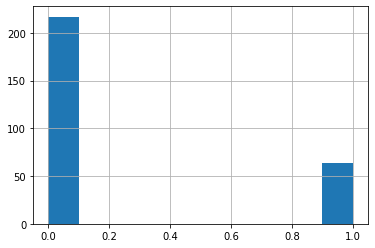

In [47]:
df_final.job_hopper.hist()


In [48]:
df_final.to_csv("../result/avg_work_exp.csv", index=False)
